In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Feb  5 14:35:35 2025
@author: yuhui
"""
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
import pandas as pd
from statsmodels.stats.anova import AnovaRM
from scipy.stats import f
from scipy.stats import t

In [ ]:
# Define data directory
data_dir = '/media/yuhui/LCT/'
os.chdir(data_dir)

# Define layer parameters
layer_num = 18
depth = np.linspace(0, 1, layer_num)  # Cortical depth

# Get subject list
search_pattern = f"{data_dir}/2*/bold.sft/layerProfileSUMA/stats*.rbold.benson14_v1_ecc10less.ProbMM_valueSH.1D"
subj_list = sorted(glob.glob(search_pattern))

subj_num = len(subj_list)
print(f"Processing {subj_num} subjects")

laydiff_again_sh_norm_all = np.zeros((subj_num, layer_num))
laydiff_aloss_sh_norm_all = np.zeros((subj_num, layer_num))

lay_again_sh_all = np.zeros((subj_num, layer_num))
lay_again_norm_all = np.zeros((subj_num, layer_num))
lay_aloss_sh_all = np.zeros((subj_num, layer_num))
lay_aloss_norm_all = np.zeros((subj_num, layer_num))

Processing 20 subjects


In [ ]:
# %% Loop through subjects
for subj_idx, subj_file in enumerate(subj_list):
    subj_folder = os.path.dirname(subj_file)

    # Define effect list
    effect_list = [
        os.path.join(subj_folder, 'stats.rbold.pos_PALS_vpfc.A_GAIN_norm.1D'),
        os.path.join(subj_folder, 'stats.rbold.pos_PALS_vpfc.A_GAIN_sh.1D'),
        os.path.join(subj_folder, 'stats.rbold.pos_PALS_vpfc.A_LOSS_norm.1D'),
        os.path.join(subj_folder, 'stats.rbold.pos_PALS_vpfc.A_LOSS_sh.1D')
    ]

    # Load data
    effect_all = np.zeros((len(effect_list), layer_num))
    for idx, effect_file in enumerate(effect_list):
        effect_data = np.loadtxt(effect_file)

        effect_pc = effect_data[0, :]
        effect_pc = np.flip(effect_pc)
        effect_all[idx, :] = effect_pc

    lay_again_sh_all[subj_idx, :] = effect_all[1, :]
    lay_again_norm_all[subj_idx, :] = effect_all[0, :]
    lay_aloss_sh_all[subj_idx, :] = effect_all[3, :]
    lay_aloss_norm_all[subj_idx, :] = effect_all[2, :]
   
    # normalize it to get rid of the BOLD superficial bias
    laydiff_again_sh_norm_all[subj_idx, :] = lay_again_sh_all[subj_idx, :] / lay_again_norm_all[subj_idx, :]
    laydiff_aloss_sh_norm_all[subj_idx, :] = lay_aloss_sh_all[subj_idx, :] / lay_aloss_norm_all[subj_idx, :]

In [5]:
# Blue palette (e.g., Outcome Gain vs Loss)
BLUE_DARK  = "#1f77b4"   # deep blue
BLUE_LIGHT = "#6baed6"   # light blue

# Red palette (e.g., Outcome Gain vs Loss)
RED_DARK  = "#a50f15"   # deep burgundy
RED_LIGHT = "#fb6a4a"   # light red-orange (still reads as red)

color1 = RED_DARK
color2 = RED_LIGHT

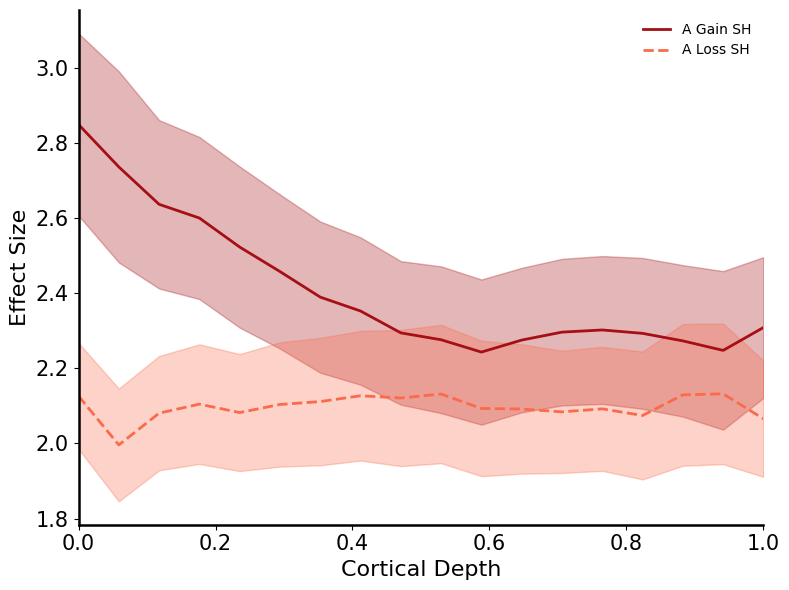

In [ ]:
# %% group laminar profile
# Compute mean and SEM across subjects
effect_mean1 = np.mean(laydiff_again_sh_norm_all, axis=0)
effect_sem1 = np.std(laydiff_again_sh_norm_all, axis=0)/np.sqrt(subj_num)

effect_mean2 = np.mean(laydiff_aloss_sh_norm_all, axis=0)
effect_sem2 = np.std(laydiff_aloss_sh_norm_all, axis=0)/np.sqrt(subj_num)

# Define plot directory
plot_dir = os.path.join(data_dir, 'group')
os.makedirs(plot_dir, exist_ok=True)
# Plot results with SINGLE Y-axis
fig, ax = plt.subplots(figsize=(8, 6))
# Plot A Gain SH (blue)
ax.fill_between(depth, effect_mean1 - effect_sem1, effect_mean1 + effect_sem1, color=color1, alpha=0.3)
ax.plot(depth, effect_mean1, '-', linewidth=2, color=color1, label="A Gain SH")
# Plot A Loss SH (red)
ax.fill_between(depth, effect_mean2 - effect_sem2, effect_mean2 + effect_sem2, color=color2, alpha=0.3)
ax.plot(depth, effect_mean2, '--', linewidth=2, color=color2, label="A Loss SH")
# Labels and Title
ax.set_xlabel('Cortical Depth', fontsize=16, fontweight='normal')
ax.set_ylabel('Effect Size', fontsize=16, fontweight='normal')
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.set_xlim([0, 1])
# Remove the box around the legend
ax.legend(frameon=False) # loc='best',
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Increase the thickness of the x and y axes
ax.spines['left'].set_linewidth(1.8)  # Y-axis thickness
ax.spines['bottom'].set_linewidth(1.8)  # X-axis thickness
plt.tight_layout()
plt.savefig("output/layerprofile.png", dpi=300, bbox_inches='tight')


In [ ]:
# %% Compare Superficial vs. Deep Layers

# Define superficial (layers 1-9) and deep (layers 10-18)
mean_superficial_again = np.mean(laydiff_again_sh_norm_all[:, 0:9], axis=1) # 0:9
mean_deep_again = np.mean(laydiff_again_sh_norm_all[:, 9:18], axis=1) # 9:18
mean_superficial_aloss = np.mean(laydiff_aloss_sh_norm_all[:, 0:9], axis=1)
mean_deep_aloss = np.mean(laydiff_aloss_sh_norm_all[:, 9:18], axis=1)

In [ ]:
subjects = np.arange(subj_num)

# Prepare data
df_anova = pd.DataFrame({
    'Subject': np.concatenate([subjects]*4),
    'Layer': ['Superficial']*subj_num + ['Deep']*subj_num + ['Superficial']*subj_num + ['Deep']*subj_num,
    'Stage': ['Choice']*2*subj_num + ['Feedback']*2*subj_num,
    'Value': np.concatenate([
        mean_superficial_again,
        mean_deep_again,
        mean_superficial_aloss,
        mean_deep_aloss
    ])
})

# Convert to categorical
df_anova['Subject'] = df_anova['Subject'].astype(str)

# Run 2x2 repeated-measures ANOVA
aov = AnovaRM(df_anova, depvar='Value', subject='Subject', within=['Layer', 'Stage'])
anova_results = aov.fit()
print(anova_results)

                  Anova
            F Value Num DF  Den DF Pr > F
-----------------------------------------
Layer        3.9017 1.0000 19.0000 0.0629
Stage        1.4517 1.0000 19.0000 0.2430
Layer:Stage  5.8895 1.0000 19.0000 0.0253



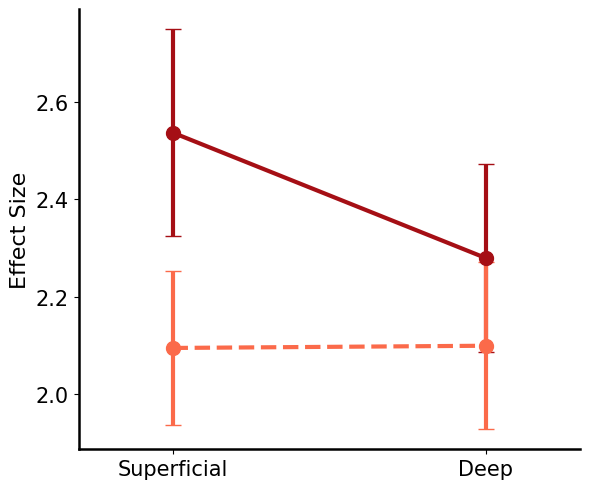

In [ ]:
means = [
    [np.mean(mean_superficial_again), np.mean(mean_deep_again)],  # A Gain SH
    [np.mean(mean_superficial_aloss), np.mean(mean_deep_aloss)]   # A Loss SH
]
sems = [
    [np.std(mean_superficial_again) / np.sqrt(len(mean_superficial_again)),
     np.std(mean_deep_again) / np.sqrt(len(mean_deep_again))],
    [np.std(mean_superficial_aloss) / np.sqrt(len(mean_superficial_aloss)),
     np.std(mean_deep_aloss) / np.sqrt(len(mean_deep_aloss))]
]

# X-axis labels and positions
x = np.arange(2)
x_labels = ["Superficial", "Deep"]

fig, ax = plt.subplots(figsize=(6, 5))

# Plot lines and error bars for A Gain SH (blue) and A Loss SH (red)
ax.errorbar(x, means[0], yerr=sems[0], color=color1, marker='o', linewidth=3, markersize=10, capsize=6, label='A Gain SH')
ax.errorbar(x, means[1], yerr=sems[1], color=color2, marker='o', linewidth=3, markersize=10, capsize=6, linestyle='--', label='A Loss SH')

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(x_labels, fontsize=16)
ax.set_ylabel("Effect Size", fontsize=16)
ax.tick_params(axis='y', labelsize=14)
# ax.set_ylim(0, y_max * 1.2)
ax.set_xlim(-0.3, 1.3)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.8)
ax.spines['bottom'].set_linewidth(1.8)

plt.tight_layout()
plt.savefig("output/layerprofile1.png", dpi=300, bbox_inches='tight')